<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Sound%20classification/Guitar_chards_dataset_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import gc
import re
import numpy as np
import torch
from imblearn.over_sampling import RandomOverSampler
#import datasets
import transformers
print(transformers.__version__)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()

4.35.2


Load the Dataset

In [ ]:
import os
from pathlib import Path
import os.path
import glob
#from pathlib import Path
import torchaudio

image_paths = glob.glob('/content/Training/**/*.wav', recursive=True)

image_labels=pd.Series([x.split("/")[-2] for x in image_paths])

In [ ]:
df=pd.DataFrame({"file":image_paths,"label":image_labels})

In [ ]:
df.shape

(1120, 2)

In [ ]:
df.head()

,file,label
0,/content/Training/G/G_AcusticPlug7_3.wav,G
1,/content/Training/G/G_AcusticPlug25_1.wav,G
2,/content/Training/G/G_AcusticPlug22_2.wav,G
3,/content/Training/G/G_RootsGB_JO_1.wav,G
4,/content/Training/G/G_RootsGB_JO_4.wav,G


In [ ]:
df['label'].value_counts()

G       140
Dm      140
Em      140
Bb      140
C       140
Am      140
F       140
Bdim    140
Name: label, dtype: int64

Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

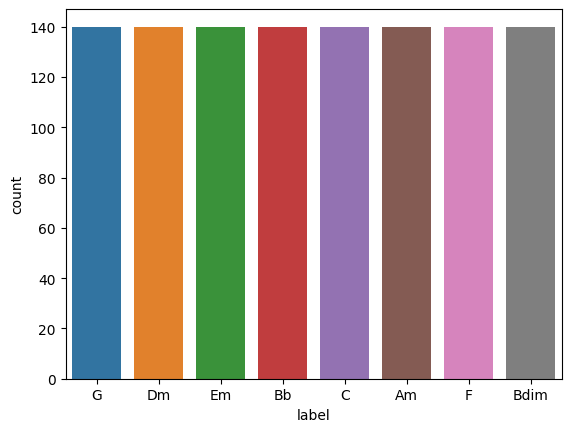

In [ ]:
sns.countplot(data=df, x='label')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

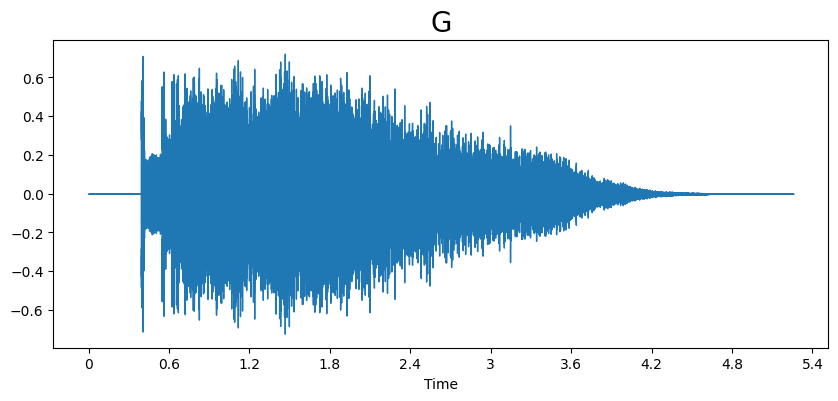

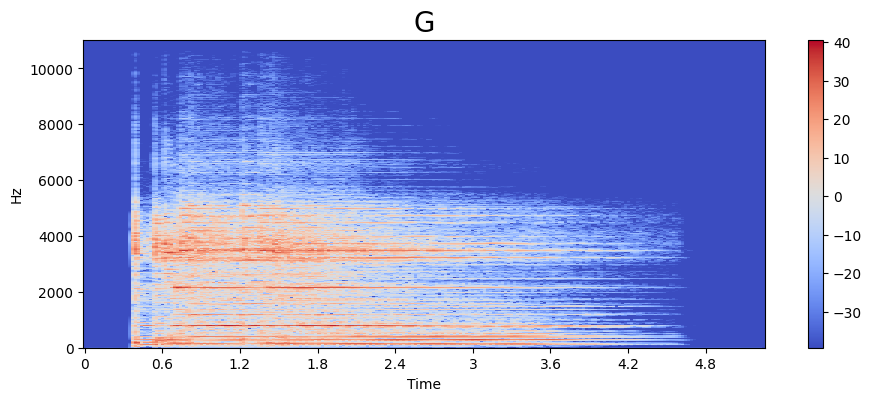

In [ ]:
emotion = 'G'
path = np.array(df['file'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

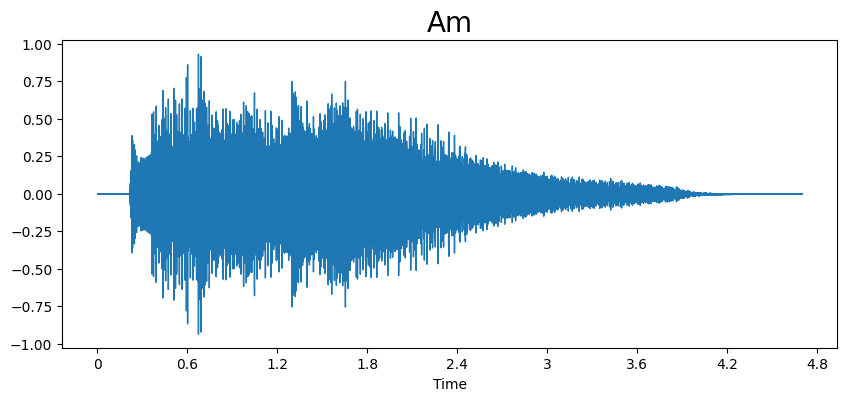

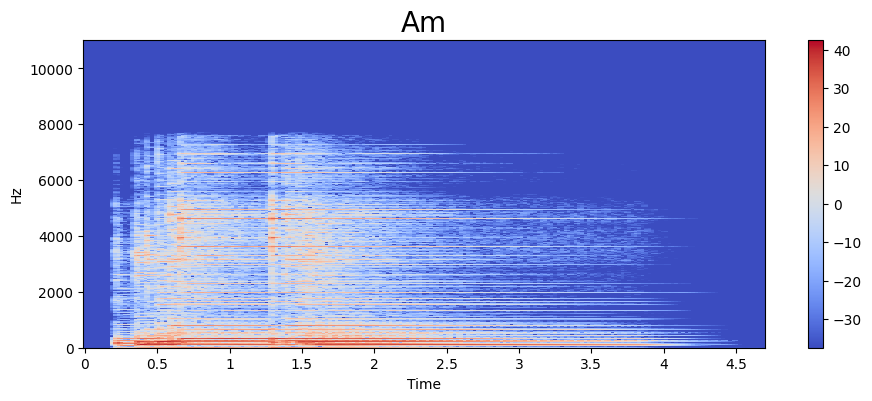

In [ ]:
emotion = 'Am'
path = np.array(df['file'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

Feature Extraction

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['file'][0])

array([-1.45462494e+02,  1.35277542e+02, -6.53004456e+01,  8.49898300e+01,
       -3.48925896e+01,  2.82050490e+00,  1.33649874e+01, -1.97278862e+01,
        4.50570250e+00,  8.63677120e+00, -1.79676857e+01, -6.09230757e+00,
       -6.37147522e+00, -1.46300049e+01, -1.90618782e+01,  5.25708628e+00,
        6.29887676e+00, -1.19412489e+01,  1.57868347e+01,  1.13593423e+00,
       -2.15997562e+01, -9.15207863e+00, -1.71038208e+01,  9.61172283e-01,
       -2.06168318e+00, -1.09700775e+01, -8.04562330e-01, -1.54078554e-03,
       -6.31602645e-01, -1.25296974e+01, -1.08246136e+01, -6.64873934e+00,
       -1.36143627e+01, -5.97157335e+00,  4.05932903e+00,  3.51452780e+00,
       -1.06910648e+01, -5.55308485e+00, -5.21491432e+00, -1.16599798e+01],
      dtype=float32)

In [ ]:
X_mfcc = df['file'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

0       [-145.4625, 135.27754, -65.300446, 84.98983, -...
1       [-284.14578, 148.88649, 8.844775, 69.27958, -1...
2       [-320.9429, 160.95358, 14.455256, 58.356506, 2...
3       [-217.74767, 153.2015, -35.500294, 80.95836, 1...
4       [-244.3475, 127.457405, -37.990513, 77.37503, ...
                              ...                        
1115    [-260.5497, 160.04898, 0.5714092, 51.315834, 1...
1116    [-206.84496, 144.7239, -59.965096, 83.260445, ...
1117    [-182.03882, 160.00235, -34.35849, 79.4803, 2....
1118    [-208.15427, 138.68875, -44.548676, 102.06749,...
1119    [-145.26656, 129.8187, -75.03605, 89.65939, -2...
Name: file, Length: 1120, dtype: object

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(1120, 40)

In [ ]:
## input split
X = np.expand_dims(X, -1)
X.shape

(1120, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

(1120, 8)

Create the LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
14/14 [==============================] - 6s 252ms/step - loss: 1.7104 - accuracy: 0.3158 - val_loss: 3.2549 - val_accuracy: 0.0000e+00
Epoch 2/50
14/14 [==============================] - 2s 176ms/step - loss: 1.2113 - accuracy: 0.5480 - val_loss: 3.6919 - val_accuracy: 0.0402
Epoch 3/50
14/14 [==============================] - 2s 155ms/step - loss: 0.7829 - accuracy: 0.7042 - val_loss: 5.1527 - val_accuracy: 0.2545
Epoch 4/50
14/14 [==============================] - 2s 155ms/step - loss: 0.4395 - accuracy: 0.8382 - val_loss: 5.2125 - val_accuracy: 0.2500
Epoch 5/50
14/14 [==============================] - 2s 155ms/step - loss: 0.3468 - accuracy: 0.8873 - val_loss: 4.9524 - val_accuracy: 0.2991
Epoch 6/50
14/14 [==============================] - 2s 146ms/step - loss: 0.2726 - accuracy: 0.9118 - val_loss: 5.0222 - val_accuracy: 0.2812
Epoch 7/50
14/14 [==============================] - 3s 220ms/step - loss: 0.2987 - accuracy: 0.8962 - val_loss: 6.0686 - val_accuracy: 0.2455
Ep

Plot the results

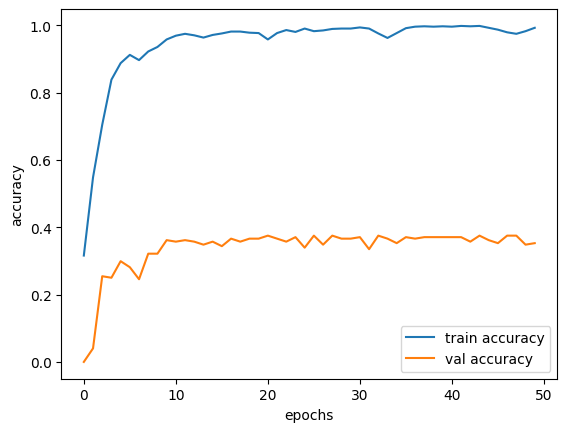

In [ ]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

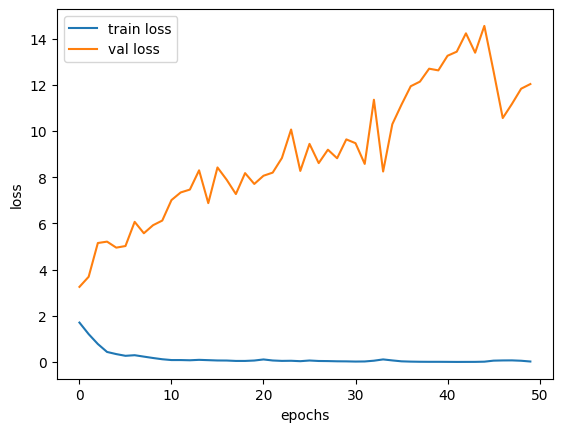

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()